# YOLO: You Only Look Once
## Unified, Real-Time Object Detection

**Paper:** Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi (2016)

---
## YOLO's Core Insight

### Detection as Regression

Instead of sliding windows or region proposals, YOLO frames detection as a **single regression problem**:

$$
f(image) \rightarrow S \times S \times (B \times 5 + C)
$$

Where:
- $S \times S$ = Grid cells (7×7 = 49 cells)
- $B$ = Bounding boxes per cell (2)
- $5$ = Box parameters $(x, y, w, h, confidence)$
- $C$ = Number of classes (20 for PASCAL VOC)

**Key Ideas:**
1. Divide image into $S \times S$ grid
2. Each grid cell predicts $B$ bounding boxes
3. Each cell also predicts class probabilities
4. Only ONE cell is "responsible" for each object (the one containing object center)

### Speed vs Accuracy Trade-off

| Method | mAP (VOC 2007) | FPS | Time per Image |
|--------|----------------|-----|----------------|
| R-CNN | 66.0% | 0.02 | ~47s |
| Fast R-CNN | 70.0% | 0.5 | ~2s |
| Faster R-CNN | 73.2% | 5 | ~0.2s |
| **YOLO** | **63.4%** | **45** | **~0.022s** |

YOLO trades some accuracy for **massive speed gains** - enabling real-time detection!

---
## Introduction & Motivation

### The Evolution of Object Detection

**Traditional Approaches:**
- **R-CNN** (2014): Region proposals → CNN features → Classification
  - Slow: ~47 seconds per image
- **Fast R-CNN** (2015): Shared computation, but still uses Selective Search
  - Faster: ~2 seconds per image
- **Faster R-CNN** (2015): RPN for proposals
  - Even faster: ~0.2 seconds per image

**The Problem:** All are **two-stage detectors**
1. Generate region proposals
2. Classify each region

**YOLO's Innovation:** **Single-stage detection** - look at the image only once!

In [ ]:
from manim import (
    BLUE,  # noqa: F401
    DOWN, # noqa: F401
    GRAY, # noqa: F401
    GRAY_B,  # noqa: F401
    GRAY_C, # noqa: F401
    GREEN,  # noqa: F401
    LEFT, # noqa: F401
    ORANGE,  # noqa: F401
    PINK,  # noqa: F401
    PURPLE,  # noqa: F401
    RED, # noqa: F401
    RIGHT, # noqa: F401
    UL, # noqa: F401
    UP, # noqa: F401
    WHITE, # noqa: F401
    YELLOW, # noqa: F401
    Arrow, # noqa: F401
    Brace,  # noqa: F401
    Create, # noqa: F401
    DashedLine,  # noqa: F401
    Dot, # noqa: F401
    FadeIn, # noqa: F401
    FadeOut,  # noqa: F401
    FadeToColor,  # noqa: F401
    Flash, # noqa: F401
    Line,  # noqa: F401
    Rectangle, # noqa: F401
    Scene, # noqa: F401
    Square, # noqa: F401
    Text, # noqa: F401
    TransformFromCopy,  # noqa: F401
    VGroup, # noqa: F401
    Wiggle,  # noqa: F401
    Write, # noqa: F401
    config,
)

# Configure Manim for notebook rendering
config.media_width = "100%"  # Width of rendered videos
config.media_embed = True  # Embed videos directly in notebook
config.verbosity = "WARNING"  # Reduce output noise

In [ ]:
# Load model and setup for demonstrations
import matplotlib.animation as mpl_animation  # Use alias to avoid conflict with manim
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from IPython.display import HTML

from yolo.models import ResNetBackbone, YOLOv1
from yolo.inference import YOLOInference

DEVICE = "cpu"
activations = {}


def hook_fn(name):
    def hook(module, input, output):
        activations[name] = output.detach().cpu()

    return hook


def register_hooks(model):
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            layer.register_forward_hook(hook_fn(name))


def load_model(
    checkpoint_path: str,
    num_classes: int = 20,
    freeze_backbone: bool = False,
    device: str = "cpu",
) -> YOLOv1:
    """Load YOLO model from checkpoint"""
    backbone = ResNetBackbone(pretrained=False, freeze=freeze_backbone)
    model = YOLOv1(backbone=backbone, num_classes=num_classes, S=7, B=2)

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device)

    return model


def visualize_activations(activations: dict) -> HTML:
    """Create animation of feature maps across layers"""
    fig, ax = plt.subplots(figsize=(8, 8))
    layer_names = list(activations.keys())

    frames = [act[0][0].detach().cpu().numpy() for act in activations.values()]

    img = ax.imshow(frames[0], cmap="viridis", animated=True)
    ax.axis("off")

    def update(i):
        img.set_array(frames[i])
        ax.set_title(f"Layer: {layer_names[i]}", fontsize=10)
        return [img]

    ani = mpl_animation.FuncAnimation(
        fig, update, frames=len(frames), interval=400, blit=True
    )
    plt.close(fig)
    return HTML(ani.to_jshtml())


print(f"Device: {DEVICE}")

Device: cpu


### Architecture Breakdown

The network can be divided into two main parts:

1. **Feature Extraction (Backbone):** 
   - 24 convolutional layers
   - Extracts semantic features from the image
   - Reduces spatial dimensions: $448 \times 448 \rightarrow 7 \times 7$
   - Increases depth: $3 \rightarrow 1024$ channels

2. **Detection Head:**
   - 2 fully connected layers
   - Converts features to predictions
   - Output: $7 \times 7 \times 30$ predictions

/Users/mattias/programmering/kthais/yolo-v1/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[11/17/25 16:28:19] INFO     HTTP Request: HEAD                                                     ]8;id=307419;file:///Users/mattias/programmering/kthais/yolo-v1/.venv/lib/python3.13/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=869693;file:///Users/mattias/programmering/kthais/yolo-v1/.venv/lib/python3.13/site-packages/httpx/_client.py#1025\1025]8;;\
                             https://huggingface.co/mattiaskvist/yolo-v1/resolve/main/yolo_best.pth                
                             "HTTP/1.1 302 Found"                                                                  

Model loaded successfully!
Total parameters: 282,245,630


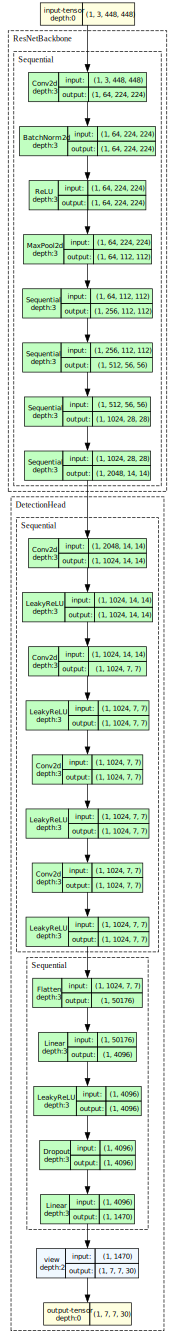

In [9]:
# Visualize the network architecture
from torchview import draw_graph
from huggingface_hub import hf_hub_download

# download weights from Hugging Face
checkpoint_path = hf_hub_download(
    repo_id="mattiaskvist/yolo-v1",
    filename="yolo_best.pth",
)

# Load model
model = load_model(
    checkpoint_path=checkpoint_path,
    device=DEVICE,
)

# Create sample input
sample_input = torch.randn(1, 3, 448, 448)

# Visualize architecture
model_graph = draw_graph(
    model,
    input_size=sample_input.shape,
    expand_nested=True,
    graph_name="YOLOv1 Architecture",
)

print("Model loaded successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

model_graph.visual_graph

In [10]:
# Initialize inference pipeline
register_hooks(model)
inference = YOLOInference(model, device=DEVICE)

---
## Inference Pipeline

### From Image to Detections

The inference process consists of several steps:

1. **Preprocessing:** Resize image to $448 \times 448$
2. **Forward Pass:** Run through network
3. **Decode Predictions:** Convert tensor to bounding boxes
4. **Confidence Filtering:** Remove low-confidence boxes
5. **Non-Maximum Suppression:** Remove duplicate detections

Original image size: (353, 500)
Preprocessed tensor shape: torch.Size([1, 3, 448, 448])


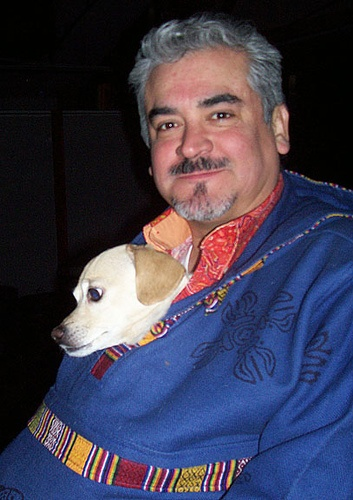

In [11]:
# Load a sample image
image_path = "sample.jpg"
image = inference.load_image(image_path)
image_tensor = inference.preprocess_image(image)

print(f"Original image size: {image.size}")
print(f"Preprocessed tensor shape: {image_tensor.shape}")

# Display original image
image

### Forward Pass Through Network

Let's visualize what happens inside the network during inference.

In [12]:
from yolo.utils import VOC_CLASSES

# Run inference with very low threshold to see all predictions
detections = inference.predict(
    image_path=image_path,
    conf_threshold=0.01,  # Very low threshold
    nms_threshold=1.0,  # No NMS yet
    class_names=VOC_CLASSES,
)

### Visualizing how the network processes an image

In [13]:
# visualize feature maps
display(visualize_activations(activations))

[11/17/25 16:28:23] INFO     Animation.save using <class 'matplotlib.animation.HTMLWriter'>       ]8;id=201629;file:///Users/mattias/programmering/kthais/yolo-v1/.venv/lib/python3.13/site-packages/matplotlib/animation.py\animation.py]8;;\:]8;id=738797;file:///Users/mattias/programmering/kthais/yolo-v1/.venv/lib/python3.13/site-packages/matplotlib/animation.py#1076\1076]8;;\

## The Grid

In [19]:
%%manim -ql -v WARNING SimpleGridDemo

class SimpleGridDemo(Scene):
    """Simple demonstration of the 7x7 grid concept"""
    def construct(self):
        # Create title
        title = Text("YOLO Grid Division", color=BLUE).scale(1.2)
        self.play(Write(title))
        self.wait(0.5)
        self.play(title.animate.to_edge(UP))
        
        # Create 7x7 grid
        S = 7
        grid = VGroup(*[
            Square(side_length=0.8, stroke_width=2, stroke_color=WHITE)
            for _ in range(S * S)
        ]).arrange_in_grid(S, S, buff=0)
        
        self.play(Create(grid))
        self.wait(0.5)
        
        # Highlight a few cells
        cells_to_highlight = [24, 25, 31, 32]  # Center cells
        highlights = VGroup(*[
            grid[i].copy().set_fill(YELLOW, opacity=0.5)
            for i in cells_to_highlight
        ])
        
        self.play(FadeIn(highlights))
        
        # Add text
        text = Text("Each cell makes predictions", color=GREEN).scale(0.6)
        text.next_to(grid, DOWN)
        self.play(Write(text))
        
        self.wait(2)

Manim Community v0.19.0

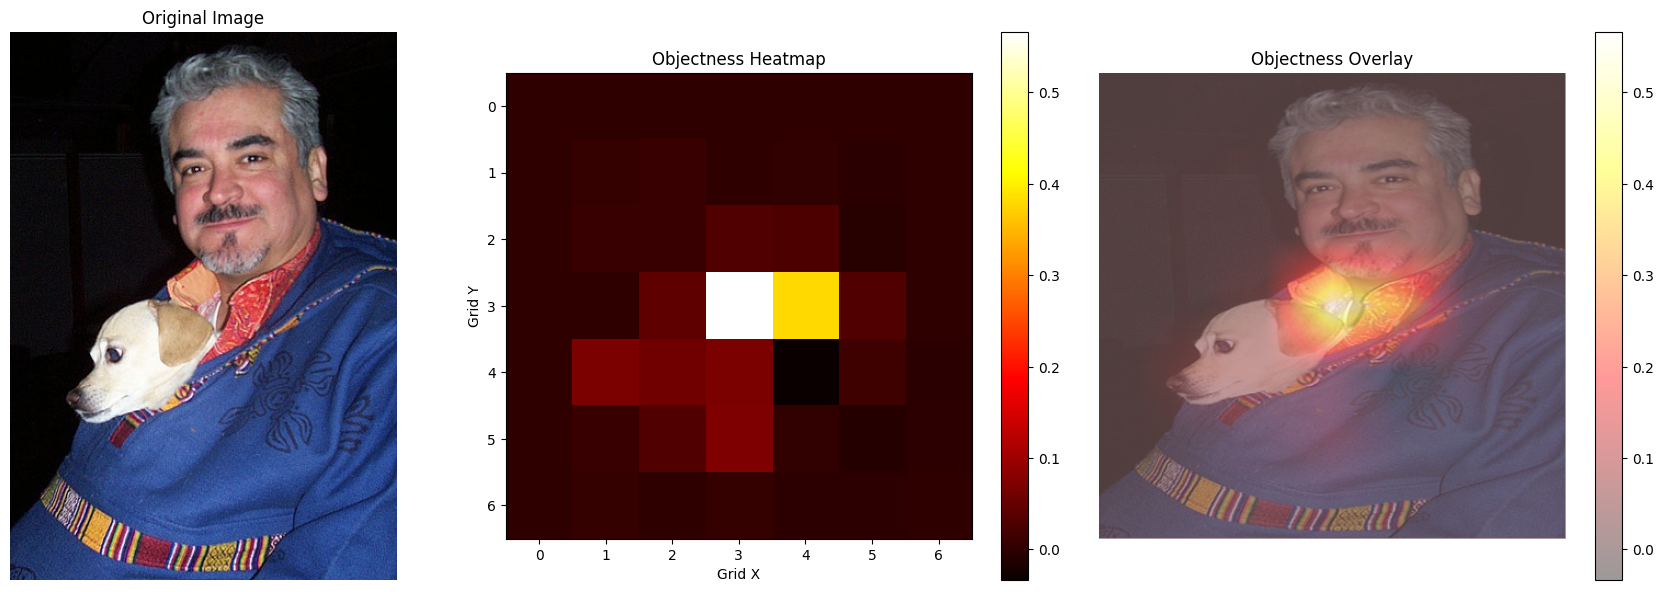

In [14]:
# Visualize objectness grid (confidence heatmap)
from yolo.utils.visualization import visualize_objectness_grid

with torch.no_grad():
    predictions = inference.model(image_tensor)

_ = visualize_objectness_grid(
    image=image,
    predictions=predictions,
)

### Objectness Grid Visualization

Each grid cell predicts confidence scores. Let's visualize which cells think they contain objects:

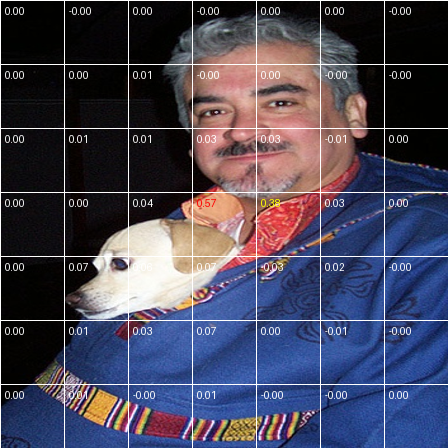

In [15]:
# Draw objectness grid overlay on original image
from yolo.utils.visualization import draw_objectness_grid_on_image

img_with_grid = draw_objectness_grid_on_image(
    image=image,
    predictions=predictions,
)
display(img_with_grid)

### Coordinate Predictions

Each grid cell predicts bounding box coordinates

In [17]:
%%manim -qm -v WARNING YoloCoordinatesInline

class YoloCoordinatesInline(Scene):
    """Animates how (x, y, w, h) are predicted."""
    def construct(self):
        S = 7
        IMG_WIDTH = 4.0

        # --- 1. Setup Context ---
        title = Text("YOLOv1: Coordinate Prediction").scale(0.8).to_edge(UP, buff=0.3)
        self.play(Write(title))

        # Show the full image/grid (small, for context)
        image_rect = Rectangle(width=IMG_WIDTH, height=IMG_WIDTH, color=GRAY_B).shift(LEFT * 4.5 + UP * 0.5)

        grid = VGroup(
            *[Square(side_length=IMG_WIDTH / S, stroke_width=1, stroke_color=GRAY_C)
              for _ in range(S * S)]
        ).arrange_in_grid(S, S, buff=0).move_to(image_rect)

        image_label = Text("Full Image Context", color=GRAY).scale(0.5).next_to(image_rect, DOWN, buff=0.2)
        self.add(image_rect, grid, image_label)

        # Show a "zoomed-in" cell
        zoomed_cell = Square(side_length=4.0, color=WHITE, stroke_width=3).shift(RIGHT * 2.5 + UP * 0.5)
        cell_label = Text("Zoomed-in Cell (i, j)").scale(0.7).next_to(zoomed_cell, UP, buff=0.2)
        self.play(Create(zoomed_cell), Write(cell_label))

        # --- 2. Define Predicted (x, y) ---
        x_pred_val = 0.7
        y_pred_val = 0.4

        cell_origin_ul = zoomed_cell.get_corner(UL)
        obj_center_abs = (
            cell_origin_ul + RIGHT * x_pred_val * zoomed_cell.width + DOWN * y_pred_val * zoomed_cell.height
        )

        obj_dot = Dot(obj_center_abs, color=RED, radius=0.08)

        # --- 3. Animate (x, y) relative to CELL ---
        x_line = Line(cell_origin_ul, cell_origin_ul + RIGHT * x_pred_val * zoomed_cell.width,
                      color=BLUE, stroke_width=5)
        x_brace = Brace(x_line, direction=DOWN, buff=0.2)
        x_label = Text(f"x = {x_pred_val}").scale(0.6).next_to(x_brace, DOWN)

        y_line = Line(x_line.get_end(), obj_dot, color=ORANGE, stroke_width=5)
        y_brace = Brace(y_line, direction=RIGHT, buff=0.2)
        y_label = Text(f"y = {y_pred_val}").scale(0.6).next_to(y_brace, RIGHT)

        xy_text = Text("(x, y) are offsets\nrelative to the cell", t2c={"(x, y)": YELLOW}).scale(0.6)
        xy_text.shift(DOWN * 3.2 + RIGHT * 2.5)

        self.play(FadeIn(obj_dot), Write(xy_text))
        self.play(Create(x_line), FadeIn(x_brace), FadeIn(x_label), run_time=1.5)
        self.play(Create(y_line), FadeIn(y_brace), FadeIn(y_label), run_time=1.5)
        self.wait(1)

        # --- 4. Define Predicted (w, h) ---
        w_pred_val = 0.3
        h_pred_val = 0.4

        # Show the predicted box
        pred_box = Rectangle(
            width=w_pred_val * IMG_WIDTH, height=h_pred_val * IMG_WIDTH,
            color=GREEN, stroke_width=3
        ).move_to(obj_dot)

        self.play(Create(pred_box))

        # Show braces on the IMAGE
        w_brace_img = Brace(image_rect, direction=DOWN, buff=0.1, color=GRAY)
        w_brace_img_label = Text("Image Width = 1.0", color=GRAY).scale(0.5).next_to(w_brace_img, DOWN)

        # Show braces on the BOX
        w_brace_box = Brace(pred_box, direction=DOWN, buff=0.1, color=GREEN)
        w_brace_box_label = Text(f"w = {w_pred_val}").scale(0.6).next_to(w_brace_box, DOWN)

        h_brace_box = Brace(pred_box, direction=LEFT, buff=0.1, color=GREEN)
        h_brace_box_label = Text(f"h = {h_pred_val}").scale(0.6).next_to(h_brace_box, LEFT)

        wh_text = Text("(w, h) are percentages\nof the TOTAL IMAGE", t2c={"(w, h)": YELLOW}).scale(0.6)
        wh_text.shift(DOWN * 3.2 + LEFT * 2.5)

        self.play(FadeIn(wh_text))
        self.play(FadeIn(w_brace_img), FadeIn(w_brace_img_label))
        self.play(TransformFromCopy(w_brace_img, w_brace_box), TransformFromCopy(w_brace_img_label, w_brace_box_label))
        self.play(FadeIn(h_brace_box), FadeIn(h_brace_box_label))
        self.wait(2)

Manim Community v0.19.0

---
## Prediction Tensor Explained

### The 30-Dimensional Output Vector

Each of the $7 \times 7 = 49$ grid cells outputs a **30-dimensional vector**:

$$
\text{Prediction Vector} = [\underbrace{x_1, y_1, w_1, h_1, c_1}_{\text{Box 1 (5)}}, \underbrace{x_2, y_2, w_2, h_2, c_2}_{\text{Box 2 (5)}}, \underbrace{p_1, p_2, \ldots, p_{20}}_{\text{Class Probabilities (20)}}]
$$

**Components:**
- **Bounding Boxes (B=2):** Each box has 5 values
  - $(x, y)$: Center coordinates relative to cell
  - $(w, h)$: Width and height relative to image
  - $c$: Confidence score (objectness)
- **Class Probabilities (C=20):** One probability per class

**Total:** $2 \times 5 + 20 = 30$ values per cell

In [ ]:
%%manim -qm -v WARNING PredictionTensorInline

class PredictionTensorInline(Scene):
    """Shows what each responsible cell predicts."""
    def construct(self):
        B = 2  # Number of bounding boxes
        C = 20  # Number of classes
        TENSOR_LENGTH = B * 5 + C  # 30

        # Title
        title = Text("YOLOv1: The Prediction Tensor").scale(0.8).to_edge(UP, buff=0.3)
        self.play(Write(title))

        # Show a highlighted cell
        cell = Square(side_length=2.0, color=YELLOW, fill_opacity=0.3).shift(LEFT * 4 + UP * 0.5)
        cell_label = Text("Responsible Cell").scale(0.6).next_to(cell, UP, buff=0.2)
        self.play(Create(cell), Write(cell_label))
        self.wait(0.5)

        # Pull out the prediction vector
        vector_start = cell.get_right()

        tensor_rect = Rectangle(
            width=6.0, height=0.4, color=WHITE, fill_opacity=0.2
        ).next_to(cell, RIGHT, buff=0.5) # <-- FIXED

        arrow = Arrow(vector_start, tensor_rect.get_left(), buff=0.1, color=WHITE)
        tensor_label = Text(f"Prediction Tensor (length {TENSOR_LENGTH})").scale(0.5)
        tensor_label.next_to(tensor_rect, UP, buff=0.2)

        self.play(Create(arrow), Create(tensor_rect), Write(tensor_label))
        self.wait(1)

        # Split into three chunks
        box1_width = (5 / TENSOR_LENGTH) * 6.0
        box2_width = (5 / TENSOR_LENGTH) * 6.0
        class_width = (C / TENSOR_LENGTH) * 6.0

        chunk1 = Rectangle(
            width=box1_width, height=0.4, color=BLUE, fill_opacity=0.5
        ).next_to(tensor_rect.get_left(), RIGHT, buff=0)
        chunk1.align_to(tensor_rect, DOWN)

        chunk2 = Rectangle(
            width=box2_width, height=0.4, color=GREEN, fill_opacity=0.5
        ).next_to(chunk1, RIGHT, buff=0)
        chunk2.align_to(tensor_rect, DOWN)

        chunk3 = Rectangle(
            width=class_width, height=0.4, color=RED, fill_opacity=0.5
        ).next_to(chunk2, RIGHT, buff=0)
        chunk3.align_to(tensor_rect, DOWN)

        chunk1_label = Text("Box 1\n(x,y,w,h,c)", color=BLUE).scale(0.4)
        chunk1_label.next_to(chunk1, DOWN, buff=0.4)

        chunk2_label = Text("Box 2\n(x,y,w,h,c)", color=GREEN).scale(0.4)
        chunk2_label.next_to(chunk2, DOWN, buff=0.4)
        chunk2_label.shift(RIGHT * 0.2)

        chunk3_label = Text("Class Probs\n(20 values)", color=RED).scale(0.4)
        chunk3_label.next_to(chunk3, DOWN, buff=0.4)

        self.play(FadeOut(tensor_rect), Create(chunk1), Create(chunk2), Create(chunk3))
        self.play(Write(chunk1_label), Write(chunk2_label), Write(chunk3_label))
        self.wait(1)

        explanation = Text(
            f"Each cell predicts {B} boxes and one set of class probabilities",
            t2c={f"{B}": YELLOW, "class probabilities": RED},
        ).scale(0.6)
        explanation.to_edge(DOWN)
        self.play(Write(explanation))
        self.wait(2)

Manim Community v0.19.0

Showing all 15 detections with confidence ≥ 0.01


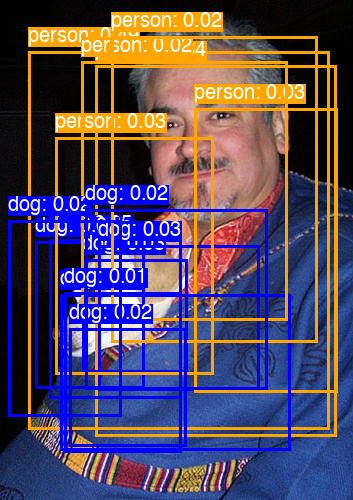

In [ ]:
# Show raw predictions (very low confidence threshold)
from yolo.utils.visualization import draw_detections

img_with_all_boxes = draw_detections(
    image=image, detections=detections, class_names=VOC_CLASSES, conf_threshold=0.01
)

print(
    f"Showing all {len([d for d in detections if d.confidence >= 0.01])} detections with confidence ≥ 0.01"
)
img_with_all_boxes

---
## Confidence Filtering

### Computing Final Confidence Scores

For each detected box, YOLO computes a **class-specific confidence score**:

$$
\text{score}_{class} = Pr(\text{Class}_i | \text{Object}) \times Pr(\text{Object}) \times \text{IoU}_{pred}^{truth}
$$

Simplified during inference:

$$
\text{score}_{class} = Pr(\text{Class}_i | \text{Object}) \times c
$$

Where:
- $Pr(\text{Class}_i | \text{Object})$ = conditional class probability
- $c$ = confidence score (objectness)

**Filtering:** Keep only boxes with $\text{score}_{class} \geq \text{threshold}$

After confidence filtering (threshold=0.1):
  Remaining detections: 2


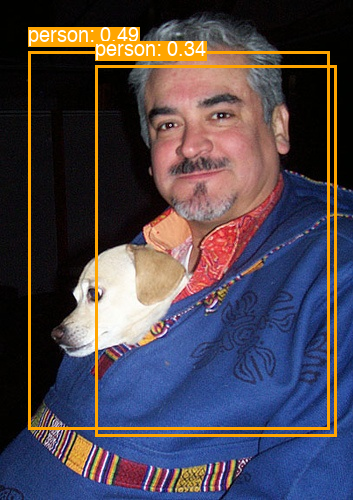

In [ ]:
# Filter by confidence threshold
CONF_THRESHOLD = 0.1

filtered_detections = [d for d in detections if d.confidence >= CONF_THRESHOLD]

img_filtered = draw_detections(
    image=image,
    detections=detections,
    class_names=VOC_CLASSES,
    conf_threshold=CONF_THRESHOLD,
)

print(f"After confidence filtering (threshold={CONF_THRESHOLD}):")
print(f"  Remaining detections: {len(filtered_detections)}")
img_filtered

## Non-Maximum Suppression (NMS) - Filter overlapping boxes

### The Problem: Multiple Detections for Same Object

Even after confidence filtering, we often get multiple overlapping boxes for the same object. This happens because:

1. **Both bounding boxes** in a cell might detect the same object
2. **Neighboring cells** might also detect objects that span multiple cells
3. **Large objects** especially trigger multiple detections

### Algorithm

**Input:** List of detections with confidence scores  
**Output:** Filtered list with no overlapping boxes

**Algorithm:**
1. Sort all boxes by confidence score (highest first)
2. Take the box with highest confidence
3. Remove all boxes with IoU > threshold with this box
4. Repeat for remaining boxes

**IoU (Intersection over Union):**

$$
\text{IoU} = \frac{\text{Area of Intersection}}{\text{Area of Union}}
$$

In [ ]:
%%manim -qm -v WARNING NonMaximalSuppressionInline

class NonMaximalSuppressionInline(Scene):
    """Demonstrates NMS to clean up overlapping boxes."""
    def construct(self):
        # Title
        title = Text("YOLOv1: Non-Maximum Suppression (NMS)").scale(0.75).to_edge(UP, buff=0.3)
        self.play(Write(title))

        # Show an image area with overlapping boxes
        image_area = Rectangle(width=5.5, height=3.5, color=GRAY_B).shift(LEFT * 2.5 + DOWN * 0.3)
        self.play(Create(image_area))

        # Three overlapping boxes for "dog"
        box_a = Rectangle(width=2.0, height=1.5, color=GREEN, stroke_width=4)
        box_a.move_to(image_area.get_center() + UP * 0.2)
        label_a = Text("A: 0.85", color=GREEN).scale(0.5).next_to(box_a, UP, buff=0.1)

        box_b = Rectangle(width=2.1, height=1.6, color=BLUE, stroke_width=4)
        box_b.move_to(image_area.get_center() + RIGHT * 0.3)
        label_b = Text("B: 0.75", color=BLUE).scale(0.5).next_to(box_b, RIGHT, buff=0.1)

        box_c = Rectangle(width=1.8, height=1.4, color=ORANGE, stroke_width=4)
        box_c.move_to(image_area.get_center() + LEFT * 0.2 + DOWN * 0.1)
        label_c = Text("C: 0.60", color=ORANGE).scale(0.5).next_to(box_c, LEFT, buff=0.1)

        self.play(Create(box_a), Write(label_a), Create(box_b), Write(label_b), Create(box_c), Write(label_c))
        self.wait(1)

        # Show NMS process
        process_title = Text("NMS Process:").scale(0.55).shift(RIGHT * 4 + UP * 2.5)
        self.play(Write(process_title))

        # Step 1: Sort by confidence
        step1 = Text("1. Keep box A (highest)", color=GREEN).scale(0.45)
        step1.next_to(process_title, DOWN, aligned_edge=LEFT, buff=0.25)
        self.play(Write(step1), Flash(box_a, color=GREEN))
        self.wait(1)

        # Step 2: Check IoU with B
        step2 = Text("2. IoU(A,B) = 0.9 > 0.5", color=BLUE).scale(0.45)
        step2.next_to(step1, DOWN, aligned_edge=LEFT, buff=0.25)
        self.play(Write(step2))
        self.wait(0.5)

        step2b = Text("   → Suppress B", color=GRAY).scale(0.45)
        step2b.next_to(step2, DOWN, aligned_edge=LEFT, buff=0.15)
        self.play(
            Write(step2b),
            box_b.animate.set_stroke(color=GRAY, opacity=0.3),
            label_b.animate.set_color(GRAY).set_opacity(0.3)
        )
        self.wait(1)

        # Step 3: Check IoU with C
        step3 = Text("3. IoU(A,C) = 0.8 > 0.5", color=ORANGE).scale(0.45)
        step3.next_to(step2b, DOWN, aligned_edge=LEFT, buff=0.25)
        self.play(Write(step3))
        self.wait(0.5)

        step3b = Text("   → Suppress C", color=GRAY).scale(0.45)
        step3b.next_to(step3, DOWN, aligned_edge=LEFT, buff=0.15)
        self.play(
            Write(step3b),
            box_c.animate.set_stroke(color=GRAY, opacity=0.3),
            label_c.animate.set_color(GRAY).set_opacity(0.3)
        )
        self.wait(1)

        # Final result
        result = Text("Final: Keep only Box A!", color=GREEN).scale(0.5)
        result.next_to(step3b, DOWN, buff=0.4)
        self.play(Write(result), Flash(box_a, color=GREEN, flash_radius=1.2))
        self.wait(2)

Manim Community v0.19.0

FINAL DETECTIONS
Confidence threshold: 0.1
NMS threshold: 0.4
Total detections: 1

Detected objects:
  1. person          0.487 at [0.51, 0.48, 0.85, 0.76]


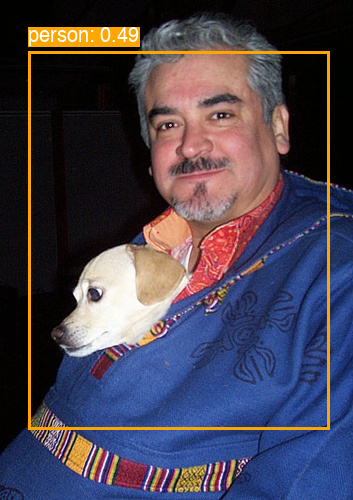

In [ ]:
# Final result: Apply both confidence threshold and NMS
FINAL_CONF_THRESHOLD = 0.1
FINAL_NMS_THRESHOLD = 0.4

final_detections = inference.predict(
    image_path=image_path,
    conf_threshold=FINAL_CONF_THRESHOLD,
    nms_threshold=FINAL_NMS_THRESHOLD,
    class_names=VOC_CLASSES,
)

img_final = draw_detections(
    image=image,
    detections=final_detections,
    class_names=VOC_CLASSES,
    conf_threshold=FINAL_CONF_THRESHOLD,
)

print("=" * 60)
print("FINAL DETECTIONS")
print("=" * 60)
print(f"Confidence threshold: {FINAL_CONF_THRESHOLD}")
print(f"NMS threshold: {FINAL_NMS_THRESHOLD}")
print(f"Total detections: {len(final_detections)}")
print("\nDetected objects:")
for i, det in enumerate(final_detections):
    bbox = det.bbox
    print(
        f"  {i + 1}. {det.class_name:15s} {det.confidence:.3f} at [{bbox.x:.2f}, {bbox.y:.2f}, {bbox.width:.2f}, {bbox.height:.2f}]"
    )

img_final

### Comparison: Before and After Post-Processing

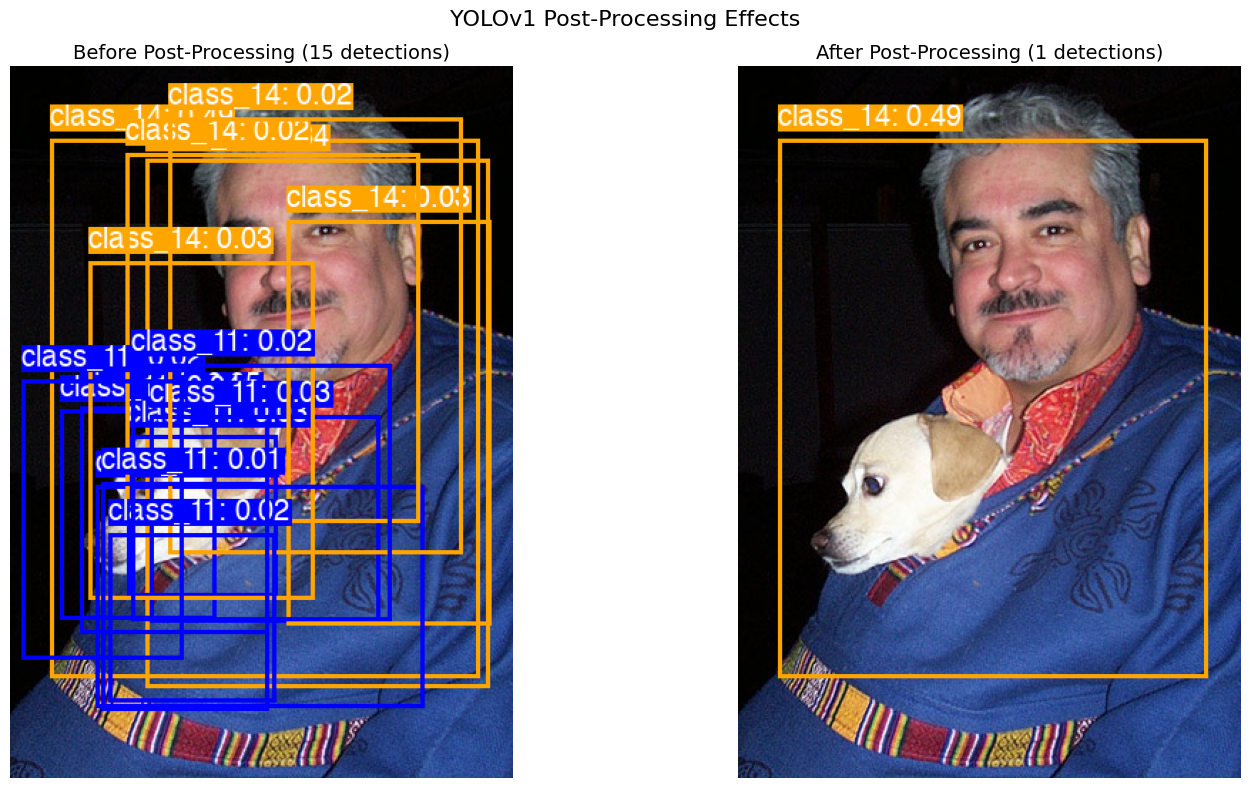

In [ ]:
# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# title
fig.suptitle("YOLOv1 Post-Processing Effects", fontsize=16)

# Before Post-Processing
dets_before = inference.predict(
    image_path="sample.jpg", conf_threshold=0.01, nms_threshold=1.0
)
img_before = draw_detections(image, dets_before, VOC_CLASSES, conf_threshold=0.01)
ax1.imshow(img_before)
ax1.set_title(f"Before Post-Processing ({len(dets_before)} detections)", fontsize=14)
ax1.axis("off")

# After Post-Processing
dets_after = inference.predict(
    image_path="sample.jpg", conf_threshold=0.1, nms_threshold=0.4
)
img_after = draw_detections(image, dets_after, VOC_CLASSES, conf_threshold=0.1)
ax2.imshow(img_after)
ax2.set_title(f"After Post-Processing ({len(dets_after)} detections)", fontsize=14)
ax2.axis("off")

plt.tight_layout()
plt.show()

---
## Results & Metrics


### Understanding Average Precision (AP)

Average Precision is the standard metric for evaluating object detection models. Let's break down how it works:

#### 1. What is Average Precision?

**Average Precision (AP)** summarizes the precision-recall curve as a single number representing the average of all precisions at different recall levels.

**Key Concepts:**
- **Precision:** What percentage of detections are correct?
  $$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$

- **Recall:** What percentage of ground truth objects are detected?
  $$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$

- **True Positive (TP):** Detection with IoU ≥ threshold (typically 0.5)
- **False Positive (FP):** Detection with IoU < threshold or duplicate detection
- **False Negative (FN):** Ground truth object that wasn't detected

#### 2. How is AP Calculated?

**Step-by-Step Process:**

1. **Sort all detections** by confidence score (highest first)
2. **For each detection**, determine if it's a TP or FP:
   - Match with ground truth box if IoU ≥ threshold
   - Each ground truth can only be matched once
3. **Compute precision and recall** at each point
4. **Interpolate the precision-recall curve**
5. **Calculate area under the curve** (this is AP)

**Mathematical Formula (PASCAL VOC style):**

$$
\text{AP} = \sum_{k=1}^{n} P(k) \Delta r(k)
$$

Where:
- $P(k)$ = precision at threshold $k$
- $\Delta r(k)$ = change in recall from threshold $k-1$ to $k$

**11-Point Interpolation (Original PASCAL VOC):**

$$
\text{AP} = \frac{1}{11} \sum_{r \in \{0, 0.1, ..., 1.0\}} P_{\text{interp}}(r)
$$

$$
P_{\text{interp}}(r) = \max_{\tilde{r} \geq r} P(\tilde{r})
$$

#### 3. IoU Thresholds

**Common AP Metrics:**

- **AP@0.5** or **AP50:** IoU threshold = 0.5 (PASCAL VOC standard)
  - More lenient, accepts "roughly correct" boxes
  
- **AP@0.75** or **AP75:** IoU threshold = 0.75
  - Stricter, requires better localization
  
- **AP@[0.5:0.95]** or **mAP:** Average over IoU thresholds from 0.5 to 0.95 (step 0.05)
  - COCO's primary metric, most comprehensive

**IoU Threshold Impact:**

| IoU Threshold | Interpretation | Use Case |
|---------------|----------------|----------|
| 0.5 | Loose matching | PASCAL VOC, general detection |
| 0.75 | Tight matching | Precise localization needed |
| 0.5:0.95 | Comprehensive | COCO, research comparisons |

#### 4. mAP: Mean Average Precision

**mAP** is the **mean** of AP across all classes:

$$
\text{mAP} = \frac{1}{C} \sum_{i=1}^{C} \text{AP}_i
$$

Where:
- $C$ = number of classes (20 for PASCAL VOC)
- $\text{AP}_i$ = Average Precision for class $i$

**Example Interpretation:**
- **mAP@0.5 = 63.4%** means on average, the model achieves 63.4% AP across all 20 classes
- Some classes may perform better (e.g., person: 80%) while others worse (e.g., bottle: 40%)

#### 5. How to Interpret AP Values

**Context Matters:**
- **Object sizes:** Small objects lower AP significantly
- **Number of classes:** More classes generally means lower mAP
- **Application requirements:** Medical imaging needs higher AP than general detection

**Common AP Breakdowns:**

- **AP_small, AP_medium, AP_large:** Performance by object size
- **AP_50, AP_75:** Performance at different IoU thresholds
- **Per-class AP:** Which objects the model detects well/poorly

**Mean Average Precision (mAP):**
- Measures detection quality across all classes
- Combines precision and recall
- IoU threshold typically 0.5 for PASCAL VOC

### Model Performance

Let's look at the actual performance of our trained model:

In [ ]:
# Load evaluation results
import os

eval_file = "../checkpoints/evaluation_results.txt"
if os.path.exists(eval_file):
    print("=" * 60)
    with open(eval_file, "r") as f:
        print(f.read())
else:
    print("Evaluation results not found. Run evaluation script first.")

YOLO v1 Evaluation Results
Checkpoint: /Users/mattias/programmering/kthais/yolo-v1/checkpoints/yolo_best.pth
Dataset: VOC2007 test
Number of images: 4952

mAP50:95: 0.2120
mAP@0.5: 0.4387
mAP@0.75: 0.1433
Precision: 0.1747
Recall: 0.5227

Size-Based Metrics:
----------------------------------------------------------------------
  Small objects  (area < 32x32):
    mAP50:95: 0.0818  (n=875)
    mAP@0.5:  0.0818
    mAP@0.75: 0.0818
  Medium objects (32x32 <= area < 96x96):
    mAP50:95: 0.0925  (n=4126)
    mAP@0.5:  0.0994
    mAP@0.75: 0.0909
  Large objects  (area >= 96x96):
    mAP50:95: 0.2619  (n=8322)
    mAP@0.5:  0.5639
    mAP@0.75: 0.1731

Per-class Average Precision:
----------------------------------------------------------------------
Class            AP50:95     AP50     AP75
----------------------------------------------------------------------
cat               0.3612   0.6954   0.2954
dog               0.3097   0.6783   0.1943
train             0.2998   0.6029   0.2254

### Performance Metrics

**Original YOLO Paper Results:**
- **mAP:** 63.4% on PASCAL VOC 2007
- **Speed:** 45 FPS (frames per second)
- **Real-time:** Yes! (~22ms per image)

**Trade-offs:**
- Faster than all two-stage detectors (R-CNN family)
- Slightly lower accuracy than Faster R-CNN (73.2% mAP)
- Struggles with small objects and objects in groups

---
## Training & Loss Function

### The Multi-Part Loss Function

YOLO's loss function combines multiple objectives to train the network end-to-end:

$$
\mathcal{L} = \mathcal{L}_{coord} + \mathcal{L}_{conf}^{obj} + \mathcal{L}_{conf}^{noobj} + \mathcal{L}_{class}
$$

#### 1. Coordinate Loss (Localization)

$$
\mathcal{L}_{coord} = \lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{obj} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 + (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2 \right]
$$

**Key Points:**
- $\lambda_{coord} = 5$ (increases importance of localization)
- $\mathbb{1}_{ij}^{obj}$ = 1 if object exists in cell $i$, box $j$ is responsible
- Square root on $w, h$ to handle different sizes better

#### 2. Confidence Loss (Objectness)

$$
\mathcal{L}_{conf}^{obj} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{obj} (C_i - \hat{C}_i)^2
$$

$$
\mathcal{L}_{conf}^{noobj} = \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{noobj} (C_i - \hat{C}_i)^2
$$

**Key Points:**
- $\lambda_{noobj} = 0.5$ (reduces weight of "no object" predictions)
- Most cells contain no objects (imbalanced data)
- $C_i$ = confidence score (predicted objectness)

#### 3. Classification Loss

$$
\mathcal{L}_{class} = \sum_{i=0}^{S^2} \mathbb{1}_i^{obj} \sum_{c \in \text{classes}} (p_i(c) - \hat{p}_i(c))^2
$$

**Key Points:**
- Only penalize classification error if object exists in cell
- Sum over all 20 classes

---
## Limitations & Future Work

### Limitations of YOLOv1

1. **Spatial Constraints**
   - Fixed grid size (7×7) limits number of predictions
   - Each cell can only detect B=2 objects
   - Problem: Dense objects or objects in groups

2. **Small Objects**
   - Coarse features at 7×7 resolution
   - Struggles with small objects (e.g., flocks of birds)

3. **Unusual Aspect Ratios**
   - Model learns from training data aspect ratios
   - Poor generalization to unusual shapes

4. **Localization Errors**
   - Treats errors in small boxes same as large boxes
   - Square root helps but not perfect

### Improvements in Later Versions

Subsequent versions of YOLO addressed many of these limitations using several key innovations. Here are some of the major improvements in the versions after YOLOv1:

1.  **Anchor Boxes (YOLOv2+):**
   To handle dense objects, later versions adopted **anchor boxes**. Instead of each cell predicting only 2 boxes, it predicts offsets for a set of pre-defined box shapes (anchors). This drastically increases the number of possible detections per cell.

2.  **Multi-Scale Predictions (YOLOv3+):**
   To find small objects, **YOLOv3** introduced predictions at three different scales (e.g., 13x13, 26x26, and 52x52). The new, higher-resolution feature maps are specifically designed to capture fine-grained details and detect small objects.

3.  **K-Means Clustering (YOLOv2+):**
   To handle varied aspect ratios, the anchor box shapes are not hand-picked. Instead, they are generated by running **k-means clustering** on the bounding box dimensions from the training dataset. This creates a much better set of "priors" for the network to start from.

4.  **IoU-Based Loss (YOLOv4+):**
   To improve localization, the simple SSE loss was replaced with **IoU (Intersection over Union) based loss functions** (like GIoU, DIoU, or CIoU). This new loss *directly* optimizes for maximizing the overlap between the predicted and ground-truth boxes, leading to much more accurate localization.

---
## Summary

### Key Takeaways

1. **Unified Detection:** YOLO treats detection as a single regression problem
   - One network, one evaluation, one loss function

2. **Speed:** Real-time performance (45 FPS)
   - Enables applications: autonomous vehicles, robotics, video analysis

3. **Grid-based Predictions:** 7×7 grid with 2 boxes per cell
   - Simple yet effective spatial division

4. **End-to-End Training:** Optimizes directly for detection performance
   - No separate proposal generation

5. **Trade-offs:** Speed for some accuracy
   - Good enough for many real-world applications
   - Foundation for future improvements

### Impact

YOLO revolutionized object detection by proving that:
- Single-stage detectors can be **both fast and accurate**
- **Real-time** object detection is practical
- **Simpler** architectures can be very effective

This work spawned an entire family of detectors and influenced countless applications in computer vision!

---

## References

**Original Paper:**
- Redmon, J., Divvala, S., Girshick, R., & Farhadi, A. (2016). *You Only Look Once: Unified, Real-Time Object Detection*. CVPR 2016.
- [Paper Link](https://arxiv.org/abs/1506.02640)

**Dataset:**
- PASCAL VOC 2007/2012
- [Original Dataset Link](http://host.robots.ox.ac.uk/pascal/VOC/)

I used versions of the dataset available on Kaggle:
- [PASCAL VOC 2007 on Kaggle](https://www.kaggle.com/datasets/zaraks/pascal-voc-2007)
- [PASCAL VOC 2012 on Kaggle](https://www.kaggle.com/datasets/huanghanchina/pascal-voc-2012)

**Implementation:**
- This notebook uses a custom PyTorch implementation
- Model checkpoints available on [Hugging Face 🤗](https://huggingface.co/mattiaskvist/yolo-v1)
- Demo is available in Hugging Face Spaces: [YOLOv1 Demo](https://huggingface.co/spaces/mattiaskvist/yolo-v1)

---

**Thank you for following along!** 🎉

*You now understand how YOLO works from first principles to implementation!*